In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [3]:
%run ../common_code.ipynb

In [4]:
data = pd.read_csv("../../datasets/Bike_Sharing_Demand.csv")

n = data.shape[0]
target = "count"
features = ['feel_temp', 'humidity', 'windspeed']
data = data[features+[target]]
n_features = len(features)
data.head(10)

,feel_temp,humidity,windspeed,count
0,14.395,0.81,0.0000,16.0
1,13.635,0.80,0.0000,40.0
2,13.635,0.80,0.0000,32.0
3,14.395,0.75,0.0000,13.0
4,14.395,0.75,0.0000,1.0
5,12.880,0.75,6.0032,1.0
6,13.635,0.80,0.0000,2.0
7,12.880,0.86,0.0000,3.0
8,14.395,0.75,0.0000,8.0
9,17.425,0.76,0.0000,14.0


In [ ]:
#data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))
#preprocessing


## Using gradient boosting regressor for experiments

In [5]:
model = GradientBoostingRegressor(n_estimators=30,)
#model = LinearRegression()
model.fit(data[features], data[target])

GradientBoostingRegressor(n_estimators=30)

## calculating individual errors

In [6]:
data_errors = data.copy(deep=True)
data_errors["ape_error"] = np.abs((data[target]-model.predict(data[features]))/data[target])
data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,feel_temp,humidity,windspeed,ape_error
0,14.395,0.81,0.0,4.644600
1,13.635,0.80,0.0,1.046492
2,13.635,0.80,0.0,1.558115
3,14.395,0.75,0.0,5.947200
4,14.395,0.75,0.0,89.313595


## discretization into gradarions

In [7]:
disc_data, pipeline_data = discretize(data_errors, features+["ape_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,feel_temp,humidity,windspeed,ape_error
0,0,2,0,0
1,0,2,0,0
2,0,2,0,0
3,0,2,0,0
4,0,2,0,2
...,...,...,...,...
17374,0,1,0,0
17375,0,1,0,0
17376,0,1,0,0
17377,0,1,0,0


In [8]:
pipeline_data["cont_features"]

['feel_temp', 'humidity', 'windspeed', 'ape_error']

In [9]:
disc_data['ape_error'].value_counts()

ape_error
0    15717
1     1409
2      253
Name: count, dtype: int64

## automatic adjustment of gradations
for features with unfair gradations kmeans split
in general gradations are up to reseacher reasoning

In [10]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [3]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7],
            v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

## rediscretization after the adjustment

In [11]:
disc_data = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
disc_data

,feel_temp,humidity,windspeed,ape_error
0,0,2,0,2
1,0,2,0,1
2,0,2,0,2
3,0,2,0,2
4,0,2,0,2
...,...,...,...,...
17374,0,1,0,0
17375,0,1,0,0
17376,0,1,0,0
17377,0,1,0,1


In [12]:
disc_data['ape_error'].value_counts()

ape_error
1    6950
2    5215
0    5214
Name: count, dtype: int64

In [13]:
current_error = data_errors["ape_error"].sum()/n
current_error

4.959611556509923

In [14]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [15]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'feel_temp': 3, 'humidity': 3, 'windspeed': 3, 'ape_error': 3}

In [18]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("ape_error", x) for x in features]

In [19]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [20]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,humidity,Discrete,disc,[],[]
1,windspeed,Discrete,disc,[humidity],[disc]
2,feel_temp,Discrete,disc,"[humidity, windspeed]","[disc, disc]"
3,ape_error,Discrete,disc,"[feel_temp, humidity]","[disc, disc]"


In [21]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [22]:
bn.distributions

{'humidity': {'cprob': [0.28171931641636455,
   0.368720870015536,
   0.34955981356809945],
  'vals': ['0', '1', '2']},
 'windspeed': {'cprob': {"['2']": [0.6330864197530864,
    0.31275720164609055,
    0.05415637860082304],
   "['1']": [0.5063982521847691, 0.41713483146067415, 0.07646691635455681],
   "['0']": [0.3194444444444444, 0.47998366013071897, 0.2005718954248366]},
  'vals': ['0', '1', '2']},
 'feel_temp': {'cprob': {"['2', '0']": [0.2719708788351534,
    0.43941757670306814,
    0.28861154446177845],
   "['2', '1']": [0.22263157894736843, 0.47, 0.30736842105263157],
   "['2', '2']": [0.3252279635258359,
    0.44984802431610943,
    0.22492401215805471],
   "['1', '0']": [0.34946070878274266,
    0.2844375963020031,
    0.36610169491525424],
   "['1', '1']": [0.32360643471754585,
    0.28095772540216984,
    0.3954358398802843],
   "['1', '2']": [0.3020408163265306, 0.373469387755102, 0.32448979591836735],
   "['0', '0']": [0.3030690537084399,
    0.24872122762148338,
    0.4

## applying YODO

In [23]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

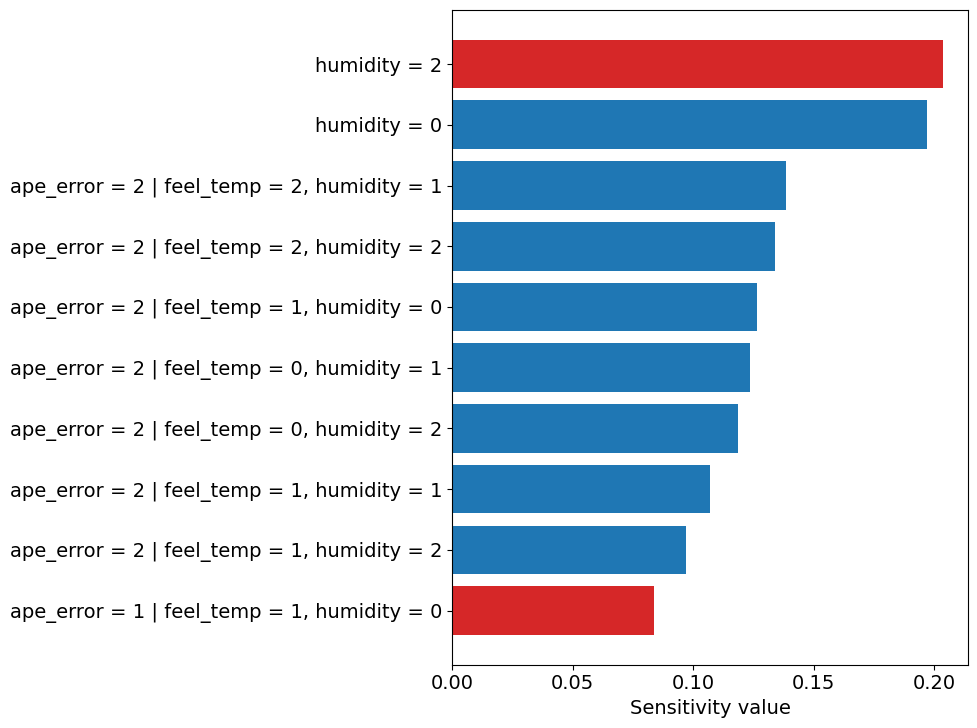

In [24]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии высокого feel_temp и среднего humidity

In [25]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as mape

In [26]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

## applying SHAP

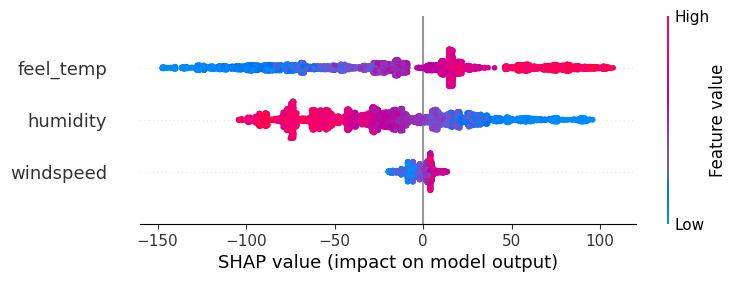

In [27]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['ape_error']==2][features])
shap.plots.beeswarm(shap_values)

трактование: больше всего на предскзаания для наблюдений с высокой ошибкой влияют feel_temp и humidity, большее влияние от соотв. низких и высоких значений (влияние на результат, дающий высокую ошибку)

## applying our approarch

In [28]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,feel_temp_0,feel_temp_1,feel_temp_2,humidity_0,humidity_1,humidity_2,windspeed_0,windspeed_1,windspeed_2,ape_error_0,ape_error_1,ape_error_2
0,1,0,0,0,0,1,1,0,0,0,0,1
1,1,0,0,0,0,1,1,0,0,0,1,0
2,1,0,0,0,0,1,1,0,0,0,0,1
3,1,0,0,0,0,1,1,0,0,0,0,1
4,1,0,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0,0,1,0,1,0,0,1,0,0
17375,1,0,0,0,1,0,1,0,0,1,0,0
17376,1,0,0,0,1,0,1,0,0,1,0,0
17377,1,0,0,0,1,0,1,0,0,0,1,0


In [29]:
from itertools import product

In [30]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "ape_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "ape_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-22 17:56:16,451 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,452 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,454 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,455 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,457 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,459 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,460 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,461 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,462 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-22 17:56:16,463 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [31]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,windspeed_0,Discrete,disc,[],[]
1,humidity_2,Discrete,disc,[windspeed_0],[disc]
2,feel_temp_1,Discrete,disc,[humidity_2],[disc]
3,feel_temp_2,Discrete,disc,[humidity_2],[disc]
4,feel_temp_0,Discrete,disc,[humidity_2],[disc]
5,ape_error_1,Discrete,disc,"[feel_temp_0, humidity_2, windspeed_0]","[disc, disc, disc]"
6,windspeed_1,Discrete,disc,"[feel_temp_0, humidity_2]","[disc, disc]"
7,humidity_0,Discrete,disc,"[feel_temp_1, windspeed_0, windspeed_1]","[disc, disc, disc]"
8,ape_error_2,Discrete,disc,"[feel_temp_2, humidity_0, humidity_2, windspee...","[disc, disc, disc, disc]"
9,windspeed_2,Discrete,disc,"[feel_temp_2, humidity_0]","[disc, disc]"


In [32]:
info = gbn.get_info()
info.iloc[8, 3]

['feel_temp_2', 'humidity_0', 'humidity_2', 'windspeed_0']

In [33]:
gbn.custom_mapper

In [ ]:
gbn.plot("bikes_regr.html")

In [36]:
dfeat = ['feel_temp', 'humidity']
dcat = [1, 2]

dfeatshap = ['feel_temp', 'humidity']
dcatshap = [0, 2]
#[feel_temp_2, humidity_0, humidity_2, windspeed_0]
dfeatbn = ['feel_temp', 'humidity', 'humidity', 'windspeed']

dcatbn = [2, 0, 2, 0]

d_dict={
    'yodo': [['feel_temp', 'humidity'], [1, 2]],
    'bn': [['feel_temp', 'humidity', 'humidity', 'windspeed'], [2, 0, 2, 0]],
    'shap': [['feel_temp', 'humidity'], [0, 2]]
}

bn = n


In [37]:
n

17379

In [28]:
data.shape

(4175, 8)

## run 1: alpha=0.8

In [ ]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [lambda x, y: mape(x, y)*100, 
                                    lambda x, y: r2_score(x, y)*100], trials=250,alpha=0.8, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)


In [50]:
stats_res['avg_n_dropped']

{'yodo': 1856.96, 'bn': 2845.772, 'shap': 1973.784, 'init': -1, 'random': -1}

In [51]:
{k: v/n for k, v in stats_res['avg_n_dropped'].items()}

{'yodo': 0.10685079693883423,
 'bn': 0.16374774152713045,
 'shap': 0.11357293284999137,
 'init': -5.754071005236205e-05,
 'random': -5.754071005236205e-05}

In [52]:
def plot_scores(metrics, graph_label, k):
    avg_metric = {}
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        avg_metric[names_mapping[name]] = sum(metrics[name][k])/len(metrics[name][k])

    plt.legend()
    plt.xlabel(graph_label)
    return avg_metric

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

In [42]:
def extended_experiments_output(stats_dictionary, metrics_labels_list):
    tbl_scores = pd.DataFrame(columns=['method', 'metric', 'value'])
    i=0
    for k, label in enumerate(metrics_labels_list):
        plt.figure()
        avg_stats = plot_scores(stats_dictionary, label, k)
        for key, val in avg_stats.items():
            tbl_scores.loc[i, :] = [key, label, val]
            i+=1
    return pd.pivot(tbl_scores, index='metric', columns='method')


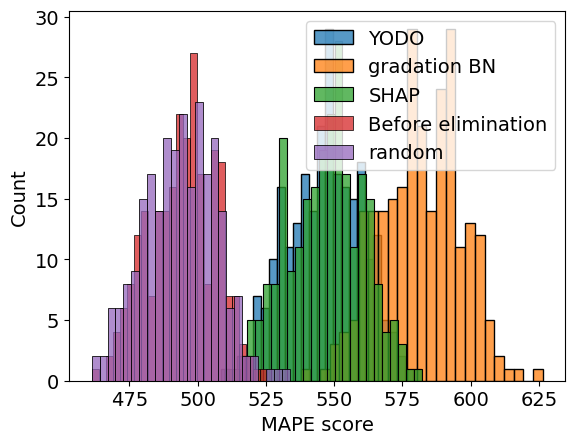

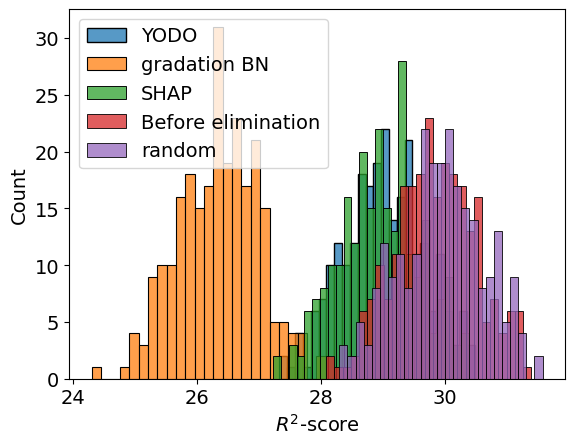

In [58]:
res_train_tbl = extended_experiments_output(stats_res['metrics'], ['MAPE score', '$R^2$-score'])

In [59]:
res_train_tbl

value                                                
method      Before elimination       SHAP        YODO gradation BN      random
metric                                                                        
$R^2$-score          29.848437  28.951803   29.011141    26.347115   29.946295
MAPE score          494.456491  546.98769  546.225343   581.692716  493.743362

In [60]:
print(res_train_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 29.848437 & 28.951803 & 29.011141 & 26.347115 & 29.946295 \\
MAPE score & 494.456491 & 546.987690 & 546.225343 & 581.692716 & 493.743362 \\
\bottomrule
\end{tabular}



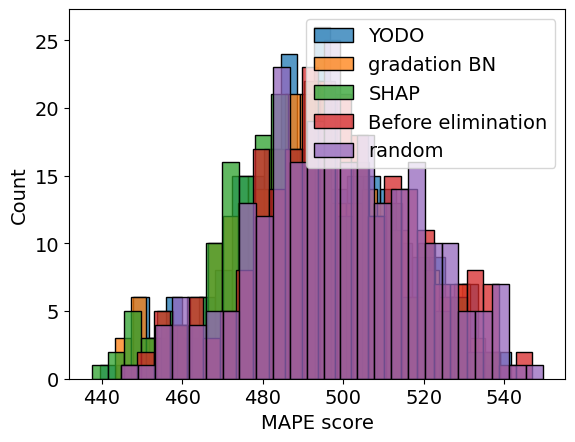

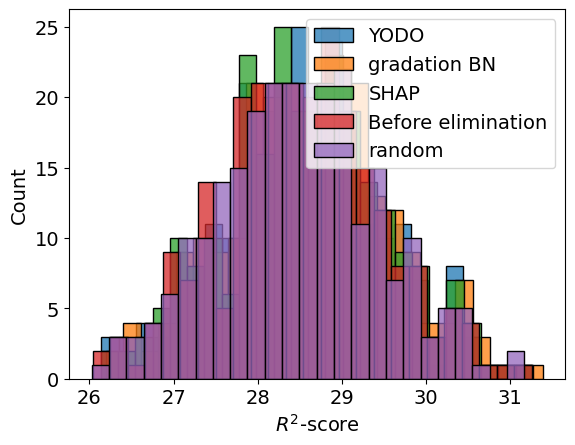

In [61]:
res_test_tbl = extended_experiments_output(stats_res['metrics_test'], ['MAPE score', '$R^2$-score'])

In [62]:
res_test_tbl

value                                       \
method      Before elimination        SHAP        YODO gradation BN   
metric                                                                
$R^2$-score          28.501042   28.564999   28.510879    28.621624   
MAPE score          498.419782  490.532385  493.222896   492.198255   

                         
method           random  
metric                   
$R^2$-score   28.478136  
MAPE score   498.540354

In [63]:
print(res_test_tbl.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 28.501042 & 28.564999 & 28.510879 & 28.621624 & 28.478136 \\
MAPE score & 498.419782 & 490.532385 & 493.222896 & 492.198255 & 498.540354 \\
\bottomrule
\end{tabular}



In [64]:
def avg_prcnt_change(stats, name1, name2, metric_num, direction=1):
    cnt = len(stats[name1][0])
    return direction*sum((a-b)/b for a, b in zip(stats[name1][metric_num], stats[name2][metric_num]))/cnt*100

In [65]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0, -1) #

1.2488840687299836

In [67]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, 1)

0.42134302271114554

In [68]:
from scipy.stats import ttest_rel

In [69]:
ttest_rel(stats_res['metrics']['bn'][0], stats_res['metrics']['init'][0]) #['MAPE score', '$R^2$-score']

TtestResult(statistic=282.99282393648133, pvalue=2.349410767e-314, df=249)

In [70]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])#['MAPE score', '$R^2$-score']

TtestResult(statistic=-68.40825351282186, pvalue=1.978451701031174e-163, df=249)

In [71]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])#['MAPE score', '$R^2$-score']

TtestResult(statistic=20.26502600782762, pvalue=1.3360218765204025e-54, df=249)

In [72]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['random'][1])#['MAPE score', '$R^2$-score']

TtestResult(statistic=19.494680377415857, pvalue=5.044946256096682e-52, df=249)

## Run 2: alpha=0.9

In [73]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [lambda x, y: mape(x, y)*100, 
                                    lambda x, y: r2_score(x, y)*100], trials=250,alpha=0.9, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)

100%|██████████| 250/250 [07:27<00:00,  1.79s/it]


In [74]:
stats_res['avg_n_dropped']

{'yodo': 927.44, 'bn': 1321.272, 'shap': 985.924, 'init': -1, 'random': -1}

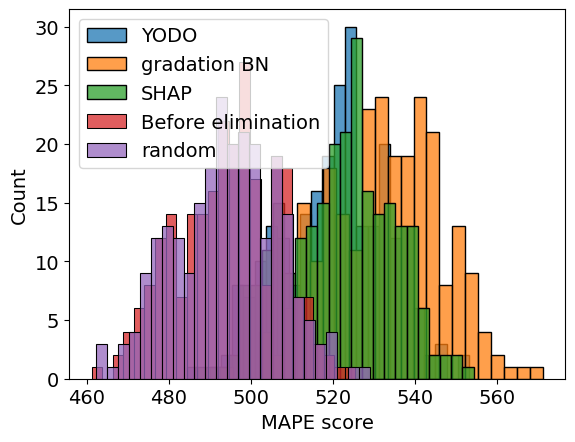

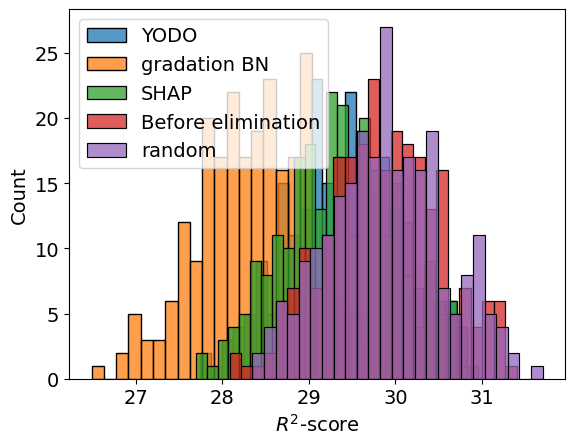

In [75]:
res_train_tbl_1 = extended_experiments_output(stats_res['metrics'], ['MAPE score', '$R^2$-score'])

In [76]:
res_train_tbl_1

value                                       \
method      Before elimination        SHAP        YODO gradation BN   
metric                                                                
$R^2$-score          29.848437   29.347316   29.415204    28.380535   
MAPE score          494.456491  521.615375  520.473061   532.640262   

                         
method           random  
metric                   
$R^2$-score   29.896314  
MAPE score   494.040243

In [77]:
print(res_train_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 29.848437 & 29.347316 & 29.415204 & 28.380535 & 29.896314 \\
MAPE score & 494.456491 & 521.615375 & 520.473061 & 532.640262 & 494.040243 \\
\bottomrule
\end{tabular}



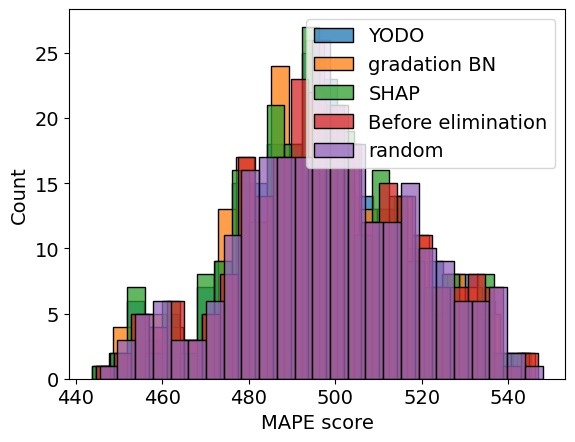

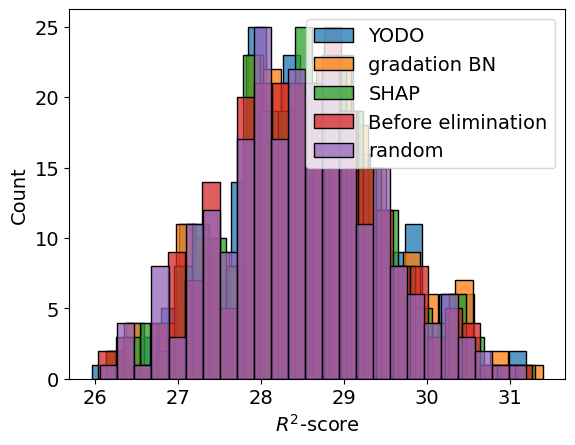

In [78]:
res_test_tbl_1 = extended_experiments_output(stats_res['metrics_test'], ['MAPE score', '$R^2$-score'])

In [79]:
res_test_tbl_1

value                                       \
method      Before elimination        SHAP        YODO gradation BN   
metric                                                                
$R^2$-score          28.501042   28.540136   28.524098    28.562464   
MAPE score          498.419782  496.440464  497.002737   496.454971   

                         
method           random  
metric                   
$R^2$-score   28.488503  
MAPE score   498.377722

In [80]:
print(res_test_tbl_1.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 28.501042 & 28.540136 & 28.524098 & 28.562464 & 28.488503 \\
MAPE score & 498.419782 & 496.440464 & 497.002737 & 496.454971 & 498.377722 \\
\bottomrule
\end{tabular}



In [81]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0)#['MAPE score', '$R^2$-score']

-0.39492517693839435

In [82]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['MAPE score', '$R^2$-score']

-0.21480307730255221

In [83]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=-28.96911804028047, pvalue=1.0361185538159562e-81, df=249)

In [84]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=14.232614886019386, pvalue=4.889285239631403e-34, df=249)

## Run 3: alpha=0.95

In [85]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [lambda x, y: mape(x, y)*100, 
                                    lambda x, y: r2_score(x, y)*100], trials=250,alpha=0.95, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)

100%|██████████| 250/250 [07:01<00:00,  1.69s/it]


In [86]:
stats_res['avg_n_dropped']

{'yodo': 442.996, 'bn': 555.16, 'shap': 462.588, 'init': -1, 'random': -1}

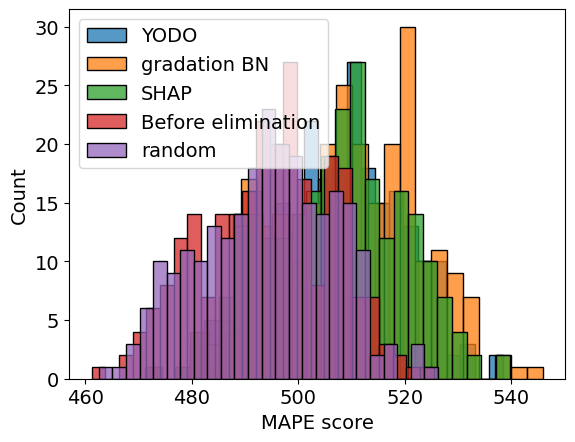

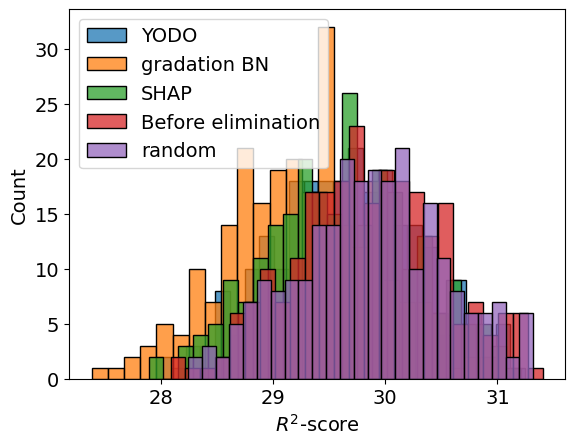

In [87]:
res_train_tbl_2 = extended_experiments_output(stats_res['metrics'], ['MAPE score', '$R^2$-score'])

In [88]:
res_train_tbl_2

value                                                
method      Before elimination        SHAP        YODO gradation BN     random
metric                                                                        
$R^2$-score          29.848437   29.611737   29.652763    29.258725   29.86265
MAPE score          494.456491  507.137056  506.810131   510.000159  494.34571

In [89]:
print(res_train_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 29.848437 & 29.611737 & 29.652763 & 29.258725 & 29.862650 \\
MAPE score & 494.456491 & 507.137056 & 506.810131 & 510.000159 & 494.345710 \\
\bottomrule
\end{tabular}



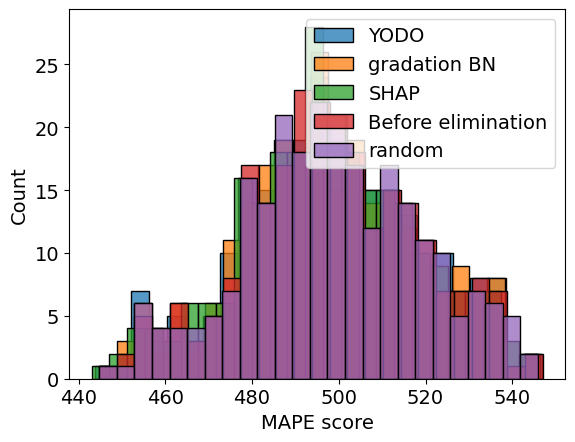

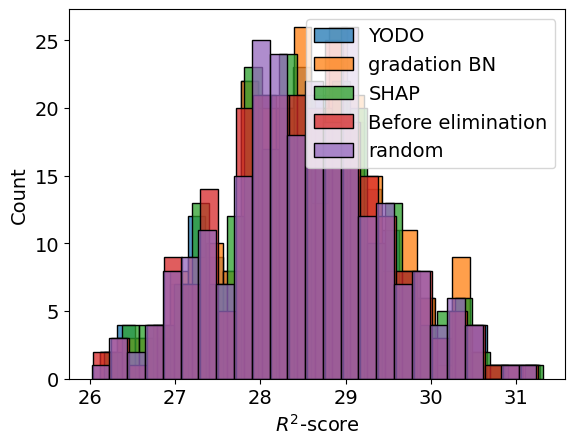

In [90]:
res_test_tbl_2 = extended_experiments_output(stats_res['metrics_test'], ['MAPE score', '$R^2$-score'])

In [91]:
res_test_tbl_2

value                                                
method      Before elimination        SHAP       YODO gradation BN      random
metric                                                                        
$R^2$-score          28.501042   28.514493  28.514846    28.536395   28.499804
MAPE score          498.419782  497.636799  497.86833   497.744779  498.422107

In [92]:
print(res_test_tbl_2.to_latex())

\begin{tabular}{llllll}
\toprule
 & \multicolumn{5}{r}{value} \\
method & Before elimination & SHAP & YODO & gradation BN & random \\
metric &  &  &  &  &  \\
\midrule
$R^2$-score & 28.501042 & 28.514493 & 28.514846 & 28.536395 & 28.499804 \\
MAPE score & 498.419782 & 497.636799 & 497.868330 & 497.744779 & 498.422107 \\
\bottomrule
\end{tabular}



In [93]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 0)#['MAPE score', '$R^2$-score']

-0.1356993699001295

In [94]:
avg_prcnt_change(stats_res['metrics_test'], 'bn', 'init', 1, -1)#['MAPE score', '$R^2$-score']

-0.12411752540679478

In [95]:
ttest_rel(stats_res['metrics_test']['bn'][0], stats_res['metrics_test']['init'][0])

TtestResult(statistic=-10.341632121255733, pvalue=4.360699263071516e-21, df=249)

In [96]:
ttest_rel(stats_res['metrics_test']['bn'][1], stats_res['metrics_test']['init'][1])

TtestResult(statistic=9.127953474696755, pvalue=2.4654437149911795e-17, df=249)